# Transfert de style

On utilise le deep learning pour transformer une image dans un autre style d'une autre image (technique décrite dans Neural Algorithm of Artistic Style).

A supprimer :

Remarque : Ce tutoriel présente l’algorithme de transfert de style original. Il optimise le contenu de l’image à un style particulier. Les approches modernes forment un modèle à générer l’image stylisée directement (similaire à CycleGAN). Cette approche est beaucoup plus rapide (jusqu’à 1000x).
Pour une application simple de transfert de style, consultez ce tutoriel pour en savoir plus sur l’utilisation du modèle de stylisation d’image arbitraire pré-dessiné de TensorFlow Hub ou sur l’utilisation d’un modèle de transfert de style avec TensorFlow Lite.

Le transfert de style neuronal est une technique d’optimisation utilisée pour prendre deux imagee :  

* une image *content* qui va être l'image ou le filtre sera appliqué
* une image *style reference*  qui sera le style à appliqué sur l'image de base
Afin d'obtenir l'image de départ avec le style de l'image entrée.

Ceci est mis en œuvre en optimisant l’image de sortie pour correspondre aux statistiques de contenu de l’image de contenu et les statistiques de style de l’image de référence de style. Ces statistiques sont extraites des images à l’aide d’un réseau convolutif.


## Configuration


### Importation et configuration des modules

In [45]:

import os
import tensorflow as tf
# Load compressed models from tensorflow_hub
os.environ['TFHUB_MODEL_LOAD_FORMAT'] = 'COMPRESSED'

In [46]:
# Importation des librairies 
import IPython.display as display

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12, 12)
mpl.rcParams['axes.grid'] = False

import numpy as np
import PIL.Image
import time
import functools

In [47]:
# Création d'une fonction pour transformer une image en tensor
def tensor_to_image(tensor):
  tensor = tensor*255
  tensor = np.array(tensor, dtype=np.uint8)
  if np.ndim(tensor)>3:
    assert tensor.shape[0] == 1
    tensor = tensor[0]
  return PIL.Image.fromarray(tensor)

Chargement des images


In [48]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [49]:
# Chargemement et stockage des images

# Image à styliser
content_path = ('/content/drive/MyDrive/Projet transfert learning/Images/Image à styliser/macron.jpg')
# Image style à appliquer
style_path = ('/content/drive/MyDrive/Projet transfert learning/Images/Style/MicrosoftTeams-image.png')

## Visualiser la saisie

In [50]:
# Définition d'une fonction pour charger une image et limiter sa dimension maximale à 512 pixels.
def load_img(path_to_img):
  max_dim = 512
  img = tf.io.read_file(path_to_img)
  img = tf.image.decode_image(img, channels=3)
  img = tf.image.convert_image_dtype(img, tf.float32)

  shape = tf.cast(tf.shape(img)[:-1], tf.float32)
  long_dim = max(shape)
  scale = max_dim / long_dim

  new_shape = tf.cast(shape * scale, tf.int32)

  img = tf.image.resize(img, new_shape)
  img = img[tf.newaxis, :]
  return img

Create a simple function to display an image:

In [51]:
# Définition d'une fonction pour visualiser les images
def imshow(image, title=None):
  if len(image.shape) > 3:
    image = tf.squeeze(image, axis=0)

  plt.imshow(image)
  if title:
    plt.title(title)

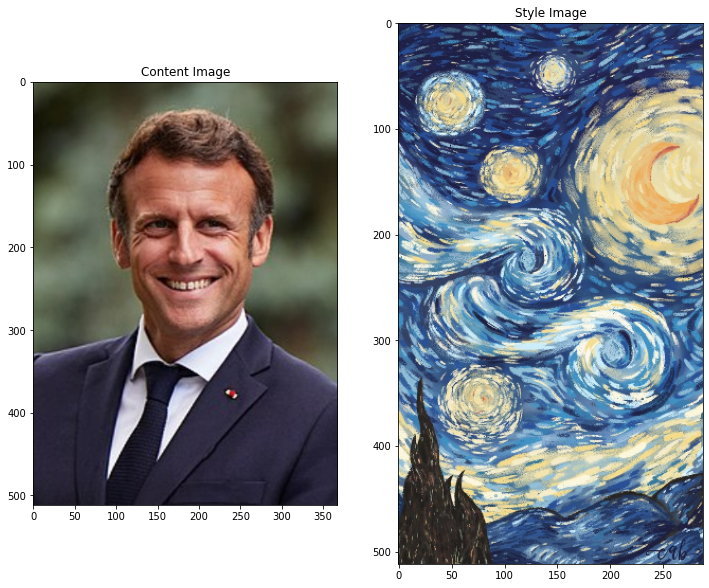

In [52]:
# Visualisation des 2 images (l'image de base à styliser et l'image style à appliquer)
content_image = load_img(content_path)
style_image = load_img(style_path)

plt.subplot(1, 2, 1)
imshow(content_image, 'Content Image')

plt.subplot(1, 2, 2)
imshow(style_image, 'Style Image')

## Transfert rapide avec : TF-Hub
Ce tutoriel présente l’algorithme de transfert de style original, qui optimise le contenu de l’image à un style particulier. Avant d’entrer dans les détails, voyons comment le modèle TensorFlow Hub fait ceci : https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/2

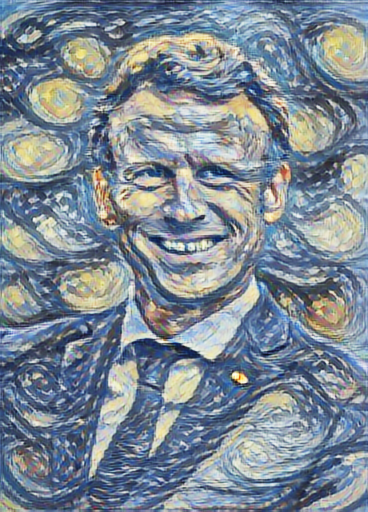

In [53]:
# Importation de la librairie
import tensorflow_hub as hub

# Chargement du modèle
hub_model = hub.load('https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/2')

# Application du style de l'image
stylized_image = hub_model(tf.constant(content_image), tf.constant(style_image))[0]

# Transformation de l'image en Tensor
tensor_to_image(stylized_image)

## Define content and style representations


Utilisez les calques intermédiaires du modèle pour obtenir les représentations *content* et *style* de l’image. À partir de la couche d’entrée du réseau, les premières activations de couche représentent des fonctionnalités de bas niveau comme les bords et les textures. Au fur et à mesure que vous avancez dans le réseau, les dernières couches représentent des caractéristiques de niveau supérieur : des parties d’objet comme *wheels* ou *eyes*. Dans ce cas, vous utilisez l’architecture réseau VGG19, un réseau de classification d’images pré-dessiné. Ces couches intermédiaires sont nécessaires pour définir la représentation du contenu et du style à partir des images. Pour une image d’entrée, essayez de faire correspondre les représentations cibles de style et de contenu correspondantes à ces couches intermédiaires.

Chargement de VGG19 et test sur notre image :

In [16]:
x = tf.keras.applications.vgg19.preprocess_input(content_image*255)
x = tf.image.resize(x, (224, 224))
vgg = tf.keras.applications.VGG19(include_top=True, weights='imagenet')
prediction_probabilities = vgg(x)
prediction_probabilities.shape

574726144/574710816 [==============================] - 3s 0us/step


TensorShape([1, 1000])

In [17]:
predicted_top_5 = tf.keras.applications.vgg19.decode_predictions(prediction_probabilities.numpy())[0]
[(class_name, prob) for (number, class_name, prob) in predicted_top_5]

49152/35363 [=========================================] - 0s 0us/step


[('church', 0.27439967),
 ('stupa', 0.19490166),
 ('palace', 0.14784524),
 ('castle', 0.12217391),
 ('bell_cote', 0.04879672)]

Chargez maintenant un VGG19 sans la tête de classification, et listez les noms de calques

In [18]:
vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')

print()
for layer in vgg.layers:
  print(layer.name)

80150528/80134624 [==============================] - 0s 0us/step

input_2
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


Choisissez des calques intermédiaires dans le réseau pour représenter le style et le contenu de l’image :


In [19]:
content_layers = ['block5_conv2'] 

style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1', 
                'block4_conv1', 
                'block5_conv1']

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

#### Couches intermédiaires pour le style et le contenu

Alors pourquoi ces sorties intermédiaires au sein de notre réseau de classification d’images pré-dessinées nous permettent-elles de définir des représentations de style et de contenu ?

À un haut niveau, pour qu’un réseau puisse effectuer une classification d’image (ce que ce réseau a été formé à faire), il doit comprendre l’image. Cela nécessite de prendre l’image brute comme pixels d’entrée et de construire une représentation interne qui convertit les pixels de l’image brute en une compréhension complexe des caractéristiques présentes dans l’image.

C’est aussi une raison pour laquelle les réseaux de neurones convolutifs sont capables de bien généraliser : ils sont capables de capturer les invariances et les caractéristiques définissant les classes (par ex. chats vs. chiens) qui sont agnostiques au bruit de fond et autres nuisances. Ainsi, quelque part entre l’endroit où l’image brute est introduite dans le modèle et l’étiquette de classification de sortie, le modèle sert d’extracteur de caractéristiques complexe. En accédant aux couches intermédiaires du modèle, vous pouvez décrire le contenu et le style des images d’entrée.

## Construire le modèle
Les réseaux dans les `tf.keras.applications` sont conçus pour que vous puissiez facilement extraire les valeurs de couche intermédiaire à l’aide de l’API fonctionnelle Keras.

Pour définir un modèle à l’aide de l’API fonctionnelle, spécifiez les entrées et les sorties :

`model = Model(inputs, outputs)`

Cette fonction suivante construit un modèle VGG19 qui retourne une liste de sorties de couches intermédiaires :

In [20]:
def vgg_layers(layer_names):
  """ Creates a VGG model that returns a list of intermediate output values."""
  # Load our model. Load pretrained VGG, trained on ImageNet data
  vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
  vgg.trainable = False
  
  outputs = [vgg.get_layer(name).output for name in layer_names]

  model = tf.keras.Model([vgg.input], outputs)
  return model

Pour créer le modèle :

In [21]:
style_extractor = vgg_layers(style_layers)
style_outputs = style_extractor(style_image*255)

#Look at the statistics of each layer's output
for name, output in zip(style_layers, style_outputs):
  print(name)
  print("  shape: ", output.numpy().shape)
  print("  min: ", output.numpy().min())
  print("  max: ", output.numpy().max())
  print("  mean: ", output.numpy().mean())
  print()

block1_conv1
  shape:  (1, 512, 288, 64)
  min:  0.0
  max:  822.6336
  mean:  31.269073

block2_conv1
  shape:  (1, 256, 144, 128)
  min:  0.0
  max:  3548.7869
  mean:  198.0245

block3_conv1
  shape:  (1, 128, 72, 256)
  min:  0.0
  max:  8667.615
  mean:  201.6766

block4_conv1
  shape:  (1, 64, 36, 512)
  min:  0.0
  max:  19798.668
  mean:  730.1427

block5_conv1
  shape:  (1, 32, 18, 512)
  min:  0.0
  max:  2958.8518
  mean:  61.68908



## Calculer le style

Le contenu d’une image est représenté par les valeurs des cartes de caractéristiques intermédiaires.

Il s’avère que le style d’une image peut être décrit par les moyens et les corrélations entre les différentes cartes de caractéristiques. Calculer une matrice Gram qui inclut cette information en prenant le produit extérieur du vecteur caractéristique avec lui-même à chaque emplacement, et en faisant la moyenne de ce produit extérieur sur tous les emplacements. Cette matrice Gram peut être calculée pour une couche particulière comme :


$$G^l_{cd} = \frac{\sum_{ij} F^l_{ijc}(x)F^l_{ijd}(x)}{IJ}$$

Ceci peut être implémenté de manière concise en utilisant la fonction : `tf.linalg.einsum`

In [22]:
def gram_matrix(input_tensor):
  result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
  input_shape = tf.shape(input_tensor)
  num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
  return result/(num_locations)

## Extraction du style et du contenu


Créez un modèle qui renvoie le style et les tenseurs de contenu.

In [23]:

class StyleContentModel(tf.keras.models.Model):
  def __init__(self, style_layers, content_layers):
    super(StyleContentModel, self).__init__()
    self.vgg = vgg_layers(style_layers + content_layers)
    self.style_layers = style_layers
    self.content_layers = content_layers
    self.num_style_layers = len(style_layers)
    self.vgg.trainable = False

  def call(self, inputs):
    "Expects float input in [0,1]"
    inputs = inputs*255.0
    preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
    outputs = self.vgg(preprocessed_input)
    style_outputs, content_outputs = (outputs[:self.num_style_layers],
                                      outputs[self.num_style_layers:])

    style_outputs = [gram_matrix(style_output)
                     for style_output in style_outputs]

    content_dict = {content_name: value
                    for content_name, value
                    in zip(self.content_layers, content_outputs)}

    style_dict = {style_name: value
                  for style_name, value
                  in zip(self.style_layers, style_outputs)}

    return {'content': content_dict, 'style': style_dict}

*Quand* il est appelé sur une image, ce modele retourne la matrice de Gram (style) du `style_layers` et le contenu du `content_layers`:

In [24]:
extractor = StyleContentModel(style_layers, content_layers)

results = extractor(tf.constant(content_image))

print('Styles:')
for name, output in sorted(results['style'].items()):
  print("  ", name)
  print("    shape: ", output.numpy().shape)
  print("    min: ", output.numpy().min())
  print("    max: ", output.numpy().max())
  print("    mean: ", output.numpy().mean())
  print()

print("Contents:")
for name, output in sorted(results['content'].items()):
  print("  ", name)
  print("    shape: ", output.numpy().shape)
  print("    min: ", output.numpy().min())
  print("    max: ", output.numpy().max())
  print("    mean: ", output.numpy().mean())


Styles:
   block1_conv1
    shape:  (1, 64, 64)
    min:  0.0890492
    max:  12574.524
    mean:  606.70526

   block2_conv1
    shape:  (1, 128, 128)
    min:  0.0
    max:  100343.41
    mean:  13033.816

   block3_conv1
    shape:  (1, 256, 256)
    min:  0.0
    max:  271374.75
    mean:  10743.848

   block4_conv1
    shape:  (1, 512, 512)
    min:  0.0
    max:  2578431.2
    mean:  161712.45

   block5_conv1
    shape:  (1, 512, 512)
    min:  0.0
    max:  100388.35
    mean:  1518.1218

Contents:
   block5_conv2
    shape:  (1, 32, 17, 512)
    min:  0.0
    max:  1230.9008
    mean:  12.245081


## Run gradient descent

Avec cette extracteur de style et de contenu, on peut maintenant implementer l'algorithme de transfer de style. On fait cela en calculant la mean square error pour les sorties relatives de notre image pour chaque cible, puis on prend la somme des poids de cette "losses".

Parametre le style et la valeur du contenu cible :

In [25]:
style_targets = extractor(style_image)['style']
content_targets = extractor(content_image)['content']

Defini une `tf.Variable` pour contenir l'image à optimiser. pour rendre cela rapide, initialiser avec le contenu de l'image (the `tf.Variable` doit avoir la même taille que le contenu de l'image):

In [26]:
image = tf.Variable(content_image)

Puisqu'il s'agit d'une float image, definir une fonction pour garder la valeur du pixel entre 0 et 1:

In [27]:
def clip_0_1(image):
  return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

Creer un optimiseur. la documentation recommande LBFGS, mais Adam marche bien également:

In [28]:
opt = tf.keras.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)

Pour otpimiser, utiliser une combination pondéré des deux losses pour avoir la loss totale:

In [29]:
style_weight=1e-2
content_weight=1e4

In [30]:
def style_content_loss(outputs):
    style_outputs = outputs['style']
    content_outputs = outputs['content']
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-style_targets[name])**2) 
                           for name in style_outputs.keys()])
    style_loss *= style_weight / num_style_layers

    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2) 
                             for name in content_outputs.keys()])
    content_loss *= content_weight / num_content_layers
    loss = style_loss + content_loss
    return loss

Utilise `tf.GradientTape`pour mettre à jour l'image

In [31]:
@tf.function()
def train_step(image):
  with tf.GradientTape() as tape:
    outputs = extractor(image)
    loss = style_content_loss(outputs)

  grad = tape.gradient(loss, image)
  opt.apply_gradients([(grad, image)])
  image.assign(clip_0_1(image))

Nous allons lancer quelques étapes pour tester:

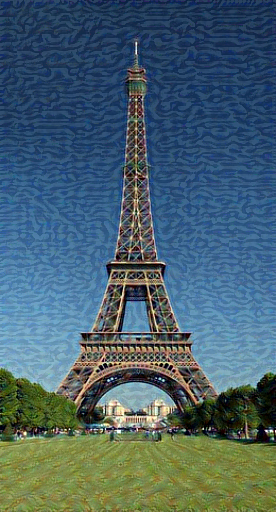

In [32]:
train_step(image)
train_step(image)
train_step(image)
tensor_to_image(image)

Bien que ce soit fonctionnelle, nous allons effectuer une plus longue optimisation:

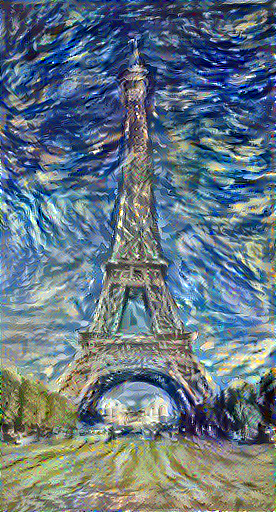

Train step: 1000
Total time: 56.5


In [33]:
import time
start = time.time()

epochs = 10
steps_per_epoch = 100

step = 0
for n in range(epochs):
  for m in range(steps_per_epoch):
    step += 1
    train_step(image)
    print(".", end='', flush=True)
  display.clear_output(wait=True)
  display.display(tensor_to_image(image))
  print("Train step: {}".format(step))
  
end = time.time()
print("Total time: {:.1f}".format(end-start))

## Total variation loss

Un inconvénient de cette implémentation de base est qu’elle produit beaucoup d’artefacts à haute fréquence. Les diminuer en utilisant un terme de régularisation explicite sur les composants haute fréquence de l’image. Dans le transfert de style, on parle souvent de perte totale de variation :

In [34]:
def high_pass_x_y(image):
  x_var = image[:, :, 1:, :] - image[:, :, :-1, :]
  y_var = image[:, 1:, :, :] - image[:, :-1, :, :]

  return x_var, y_var

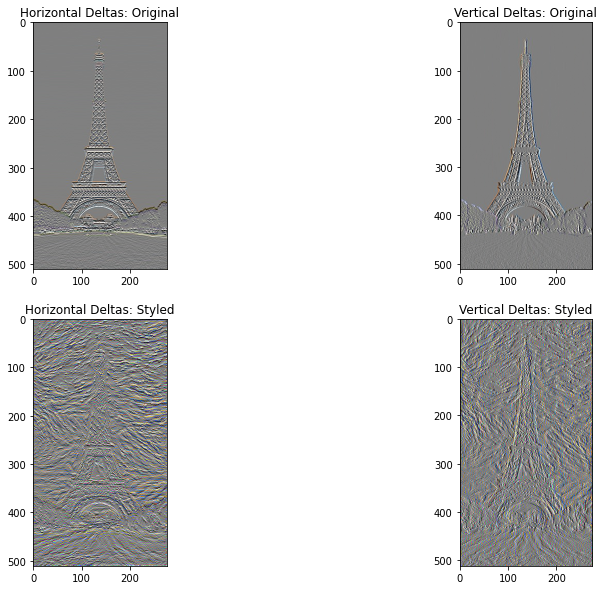

In [35]:

x_deltas, y_deltas = high_pass_x_y(content_image)

plt.figure(figsize=(14, 10))
plt.subplot(2, 2, 1)
imshow(clip_0_1(2*y_deltas+0.5), "Horizontal Deltas: Original")

plt.subplot(2, 2, 2)
imshow(clip_0_1(2*x_deltas+0.5), "Vertical Deltas: Original")

x_deltas, y_deltas = high_pass_x_y(image)

plt.subplot(2, 2, 3)
imshow(clip_0_1(2*y_deltas+0.5), "Horizontal Deltas: Styled")

plt.subplot(2, 2, 4)
imshow(clip_0_1(2*x_deltas+0.5), "Vertical Deltas: Styled")

Cela montre comment les composants haute fréquence ont augmenté.

En outre, ce composant haute fréquence est essentiellement un détecteur de bord. Vous pouvez obtenir une sortie similaire à partir du détecteur de bord Sobel, par exemple 

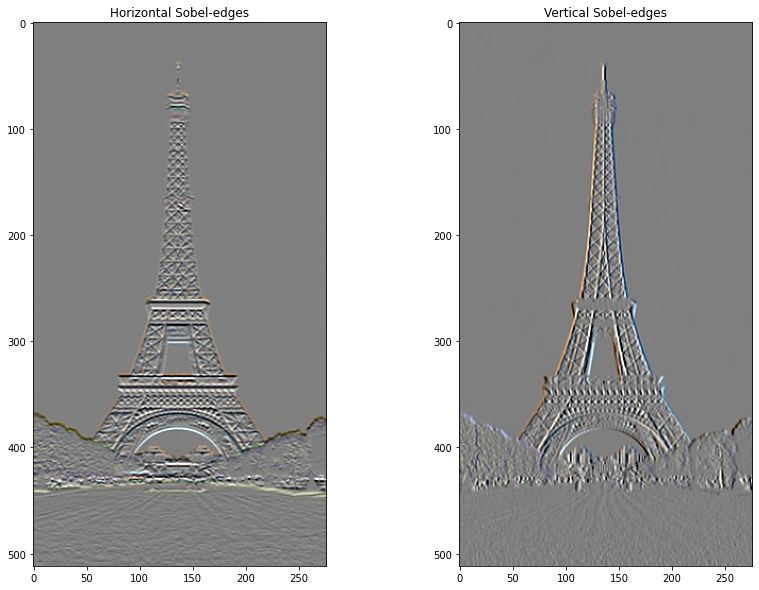

In [36]:
plt.figure(figsize=(14, 10))

sobel = tf.image.sobel_edges(content_image)
plt.subplot(1, 2, 1)
imshow(clip_0_1(sobel[..., 0]/4+0.5), "Horizontal Sobel-edges")
plt.subplot(1, 2, 2)
imshow(clip_0_1(sobel[..., 1]/4+0.5), "Vertical Sobel-edges")

La perte de régularisation associée à cela est la somme des carrés des valeurs :

In [37]:
def total_variation_loss(image):
  x_deltas, y_deltas = high_pass_x_y(image)
  return tf.reduce_sum(tf.abs(x_deltas)) + tf.reduce_sum(tf.abs(y_deltas))

In [38]:
total_variation_loss(image).numpy()

91828.75

In [39]:
tf.image.total_variation(image).numpy()

array([91828.75], dtype=float32)

## Re-run the optimization

Choisir un poid pour la `total_variation_loss`:

In [40]:
total_variation_weight=30

Nous l'incluons maintenant à la fonction `train_step`:

In [41]:
@tf.function()
def train_step(image):
  with tf.GradientTape() as tape:
    outputs = extractor(image)
    loss = style_content_loss(outputs)
    loss += total_variation_weight*tf.image.total_variation(image)

  grad = tape.gradient(loss, image)
  opt.apply_gradients([(grad, image)])
  image.assign(clip_0_1(image))

Reinitialiser la variable d'optimisation:

In [42]:
image = tf.Variable(content_image)

Lancer l'optimisation:

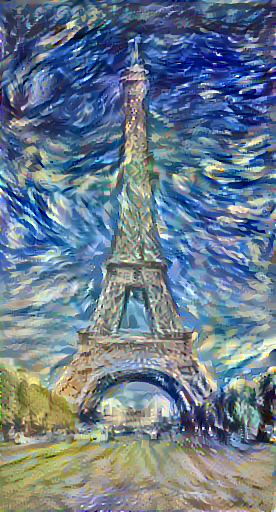

Train step: 1000
Total time: 61.2


In [43]:
import time
start = time.time()

epochs = 10
steps_per_epoch = 100

step = 0
for n in range(epochs):
  for m in range(steps_per_epoch):
    step += 1
    train_step(image)
    print(".", end='', flush=True)
  display.clear_output(wait=True)
  display.display(tensor_to_image(image))
  print("Train step: {}".format(step))

end = time.time()
print("Total time: {:.1f}".format(end-start))

Puis on sauvegarde le résultat:

In [44]:
file_name = 'stylized-image.png'
tensor_to_image(image).save(file_name)

try:
  from google.colab import files
except ImportError:
   pass
else:
  files.download(file_name)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>